## Pneumonia Detection using X-Ray images

For this example we, will use the [Pneumonia Detection](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/) challenge from Kaggle. Objective of this challenge is to use X-Ray images and detect the early signs of Pneumonia by locating lung opacities in X-ray of chest. The dataset required can be downloaded from [here](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data).

As an initial start point, we will use [this](https://www.kaggle.com/yakhyo/rsna-classification-87-6-best-accuracy-opytorch) implementation. 

This implementation uses RESNET.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

## Preparing labels

In [2]:
label_data = pd.read_csv('rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
columns = ['patientId', 'Target']
all_data = label_data

label_data = label_data.filter(columns)
label_data.head(5)
#print(all_data)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


## Dividing labels for train and validation set

In [3]:
train_labels, val_labels = train_test_split(label_data.values, test_size=0.1)
print(train_labels.shape)
print(val_labels.shape)

(27204, 2)
(3023, 2)


In [4]:
print(f'patientId: {train_labels[0][0]}, Target: {train_labels[0][1]}')

patientId: 3d59faf9-6b80-42e5-b5fb-95048344c92a, Target: 1


## Preparing train and validation image paths

In [5]:
train_f = 'rsna-pneumonia-detection-challenge/stage_2_train_images'
test_f = 'rsna-pneumonia-detection-challenge/stage_2_test_images'

train_paths = [os.path.join(train_f, image[0]) for image in train_labels]
val_paths = [os.path.join(train_f, image[0]) for image in val_labels]

print(len(train_paths))
print(len(val_paths))

27204
3023


## Show some samples from data

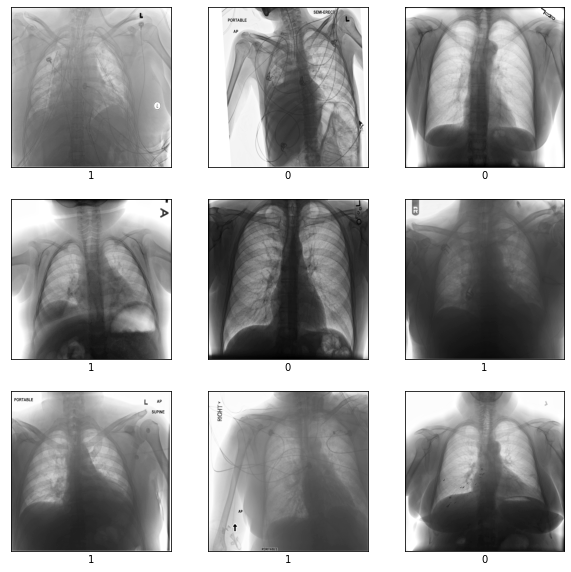

In [6]:
def imshow(num_to_show=9):
    
    plt.figure(figsize=(10,10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])

imshow()

## Composing transformations

In [7]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()])

## Write a custom dataset 

In [8]:
class Dataset(data.Dataset):
    
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0

        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')

        label = self.labels[index][1]
        
        if self.transform is not None:
            image = self.transform(image)
        
        
        name = self.paths[index].split("/")[-1]
        GH = all_data['patientId']==name
        FIL = all_data[GH]
        #print("From the datset loader, name", name)
        box = [FIL['x'].values[0], FIL['y'].values[0], FIL['width'].values[0], FIL['height'].values[0]]
            
        return image, label, box
    
    def __len__(self):
        
        return len(self.paths)

## Check the custom dataset

1 [574.0, 271.0, 286.0, 282.0]


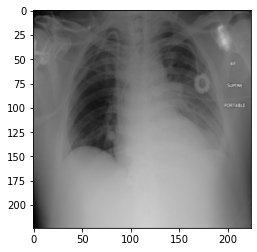

In [9]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
image = iter(train_dataset)
#print(train_dataset.paths)
img, label, box = next(image)
print(label, box)
#print(f'Tensor:{img}, Label:{label}')
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

## Train image shape

In [10]:
img.shape

torch.Size([224, 224, 3])

## Prepare training and validation dataloader

In [11]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

## Check dataloader

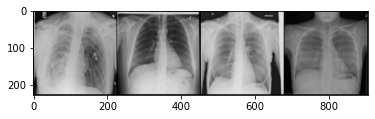

In [12]:
batch = iter(train_loader)
images, labels, _ = next(batch)

image_grid = torchvision.utils.make_grid(images[:4])
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)

## Specify device object

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load pre-trained ResNet18 and fine-tune

In [14]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Write a train code and RUN

In [16]:
num_epochs = 20
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    # Training step
    for i, (images, labels, _) in tqdm(enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


    # Validation step
    correct = 0
    total = 0  
    for images, labels, _ in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()
    print(f'Epoch: {epoch+1}/{num_epochs}, Val_Acc: {100*correct/total}')

213it [06:45,  1.90s/it]
100%|██████████| 24/24 [00:44<00:00,  1.87s/it]
0it [00:00, ?it/s]

Epoch: 1/20, Val_Acc: 81


213it [06:56,  1.95s/it]
100%|██████████| 24/24 [00:45<00:00,  1.88s/it]
0it [00:00, ?it/s]

Epoch: 2/20, Val_Acc: 82


213it [06:26,  1.81s/it]
100%|██████████| 24/24 [00:43<00:00,  1.82s/it]
0it [00:00, ?it/s]

Epoch: 3/20, Val_Acc: 82


213it [06:31,  1.84s/it]
100%|██████████| 24/24 [00:45<00:00,  1.91s/it]
0it [00:00, ?it/s]

Epoch: 4/20, Val_Acc: 81


213it [06:52,  1.94s/it]
100%|██████████| 24/24 [00:47<00:00,  2.00s/it]
0it [00:00, ?it/s]

Epoch: 5/20, Val_Acc: 82


213it [06:49,  1.92s/it]
100%|██████████| 24/24 [00:43<00:00,  1.81s/it]
0it [00:00, ?it/s]

Epoch: 6/20, Val_Acc: 81


213it [06:38,  1.87s/it]
100%|██████████| 24/24 [00:43<00:00,  1.82s/it]
0it [00:00, ?it/s]

Epoch: 7/20, Val_Acc: 83


213it [06:22,  1.79s/it]
100%|██████████| 24/24 [00:46<00:00,  1.92s/it]
0it [00:00, ?it/s]

Epoch: 8/20, Val_Acc: 82


213it [06:30,  1.83s/it]
100%|██████████| 24/24 [00:44<00:00,  1.87s/it]
0it [00:00, ?it/s]

Epoch: 9/20, Val_Acc: 84


213it [06:33,  1.85s/it]
100%|██████████| 24/24 [00:43<00:00,  1.83s/it]
0it [00:00, ?it/s]

Epoch: 10/20, Val_Acc: 83


213it [06:33,  1.85s/it]
100%|██████████| 24/24 [00:45<00:00,  1.90s/it]
0it [00:00, ?it/s]

Epoch: 11/20, Val_Acc: 84


213it [07:09,  2.01s/it]
100%|██████████| 24/24 [00:48<00:00,  2.01s/it]
0it [00:00, ?it/s]

Epoch: 12/20, Val_Acc: 85


213it [08:29,  2.39s/it]
100%|██████████| 24/24 [00:43<00:00,  1.81s/it]
0it [00:00, ?it/s]

Epoch: 13/20, Val_Acc: 84


213it [07:06,  2.00s/it]
100%|██████████| 24/24 [00:44<00:00,  1.84s/it]
0it [00:00, ?it/s]

Epoch: 14/20, Val_Acc: 85


213it [06:08,  1.73s/it]
100%|██████████| 24/24 [00:42<00:00,  1.78s/it]
0it [00:00, ?it/s]

Epoch: 15/20, Val_Acc: 84


213it [06:28,  1.82s/it]
100%|██████████| 24/24 [00:45<00:00,  1.90s/it]
0it [00:00, ?it/s]

Epoch: 16/20, Val_Acc: 86


213it [06:27,  1.82s/it]
100%|██████████| 24/24 [00:43<00:00,  1.82s/it]
0it [00:00, ?it/s]

Epoch: 17/20, Val_Acc: 85


213it [06:20,  1.79s/it]
100%|██████████| 24/24 [00:43<00:00,  1.83s/it]
0it [00:00, ?it/s]

Epoch: 18/20, Val_Acc: 85


213it [06:31,  1.84s/it]
100%|██████████| 24/24 [00:45<00:00,  1.91s/it]
0it [00:00, ?it/s]

Epoch: 19/20, Val_Acc: 86


213it [06:14,  1.76s/it]
100%|██████████| 24/24 [00:42<00:00,  1.76s/it]

Epoch: 20/20, Val_Acc: 86


## Test model

In [17]:
model.eval()

correct = 0
total = 0  
for images, labels, _ in tqdm(val_loader):
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    _, predicted = torch.max(predictions, 1)
    total += labels.size(0)
    correct += (labels == predicted).sum()
print(f'Val_Acc: {100*correct/total}')

100%|██████████| 24/24 [00:42<00:00,  1.78s/it]

Val_Acc: 86


## Save the Model weights

In [18]:
torch.save(model.state_dict(), 'weights/weights_only.pth')
torch.save(model, 'model/model.pth')
print("Model and weights saved.")

Model and weights saved.


/home/adm.akram/anaconda3/envs/medi/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/adm.akram/anaconda3/envs/medi/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/adm.akram/anaconda3/envs/medi/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/adm.akram/anaconda3/envs/medi/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correct

## Load saved model

In [19]:
model = torch.load('model/model.pth')

## Visualisation using CAM and GradCAM
We visualise these using GradCAM and GradCAM-plus-plsu. The library is obtained from the implementation [here](https://github.com/1Konny/gradcam_plus_plus-pytorch). 

In [20]:
# Import the libraries required for visualisation
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image

from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

from matplotlib import rcParams

import matplotlib.patches as patches
from math import ceil

torch.Size([224, 224, 3])
Label :  1 [595.0, 304.0, 199.0, 288.0]


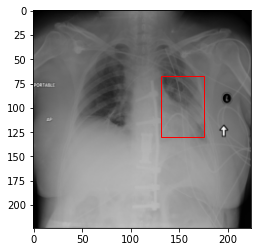

In [21]:
# Load test image
label = 0
while(label==0):
    pil_img, label, box = next(image)

fig,ax = plt.subplots(1)

Orig_img_size = 1024
img_size = 224

# 'r' means relative. 'c' means center.
rx = ceil(box[0]*img_size/Orig_img_size)
ry = ceil(box[1]*img_size/Orig_img_size)
rw = ceil(box[2]*img_size/Orig_img_size)
rh = ceil(box[3]*img_size/Orig_img_size)


pil_img = np.transpose(pil_img, (1, 2, 0))
print(pil_img.shape)
rect = patches.Rectangle((rx, ry), rw, rh, linewidth=1, edgecolor='r', facecolor='none')
ax.imshow(pil_img)
ax.add_patch(rect)
print("Label : ", label, box)


In [22]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().cuda()
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
#normed_torch_img = normalizer(torch_img)
normed_torch_img = torch_img

/home/adm.akram/anaconda3/envs/medi/lib/python3.7/site-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [23]:
cam_dict = dict()

resnet_model_dict = dict(type='resnet', arch=model, layer_name='layer4', input_size=(224, 224))
resnet_gradcam = GradCAM(resnet_model_dict, True)
resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
cam_dict['resnet'] = [resnet_gradcam, resnet_gradcampp]

saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])


torch.Size([228, 1132, 3])


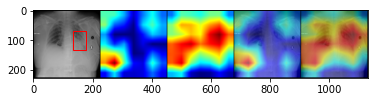

In [24]:
images = []
for gradcam, gradcam_pp in cam_dict.values():
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask.cpu(), torch_img.cpu())

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp.cpu(), torch_img.cpu())
    
    images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    
images = make_grid(torch.cat(images, 0), nrow=5)

fig,ax = plt.subplots(1)

images = np.transpose(images, (1, 2, 0))
print(images.shape)
dpi = 150
rcParams['figure.dpi']= dpi

Orig_img_size = 1024
img_size = images.shape[0]

# 'r' means relative. 'c' means center.
rx = ceil(box[0]*img_size/Orig_img_size)
ry = ceil(box[1]*img_size/Orig_img_size)
rw = ceil(box[2]*img_size/Orig_img_size)
rh = ceil(box[3]*img_size/Orig_img_size)

rect = patches.Rectangle((rx, ry), rw, rh, linewidth=1, edgecolor='r', facecolor='none')

ax.imshow(images)
ax.add_patch(rect)

# SafeML Implementation for German Pneumonia Detection
Now we will apply SafeML methodology on Pneumonia detection example.

In [25]:
# Import SafeML related libraries
import spm1d
from matplotlib import pyplot

In [27]:
# Separating Wrong Responses of the RESNET
correct = 0
total = 0
wrong_preds = None
wrong_labels = []
correct_preds = None
correct_labels = []

max_sample_size = 128

for images, labels, _ in tqdm(val_loader):
    images = images.to(device)
    a = torch.split(images, 1, dim=0)
    #a.to('cpu')
    labels = labels.to(device)
    predictions = model(images)
    _, predicted = torch.max(predictions, 1)
    total += labels.size(0)
    correct += (labels == predicted).sum()
    compare  = (labels == predicted)
    jj = 0
    for c in compare:
        if c:
            if correct_preds is None:
                correct_preds = a[jj]
            else:
                correct_preds = torch.cat((correct_preds, a[jj]), 0)
            correct_labels.append(predicted[jj])
        else:
            #print(wrong_preds.shape[0])
            if wrong_preds is None:
                wrong_preds = a[jj]
            elif max_sample_size > len(wrong_preds):
                wrong_preds = torch.cat((wrong_preds, a[jj]), 0)
                wrong_labels.append(predicted[jj])
        jj += 1
print("Number of wrong Labels: ", len(wrong_preds))

del images
del correct_preds

wrong_preds = wrong_preds.permute(0,2,3,1)
wrong_preds = wrong_preds.cpu().numpy()

#print(correct_preds.shape, wrong_preds.shape)
print(f'Val_Acc: {100*correct/total}')

100%|██████████| 24/24 [01:21<00:00,  3.38s/it]

Number of wrong Labels:  128
Val_Acc: 86


In [29]:
# Get a sample of training images

# Batch size is 128
batch = iter(train_loader)
X_train, Y_train, _ = next(batch)

X_train = X_train.permute(0,2,3,1)

# convert Tensors to ndarray
X_train = X_train.cpu().numpy()
Y_train = Y_train.cpu().numpy()

End of block.


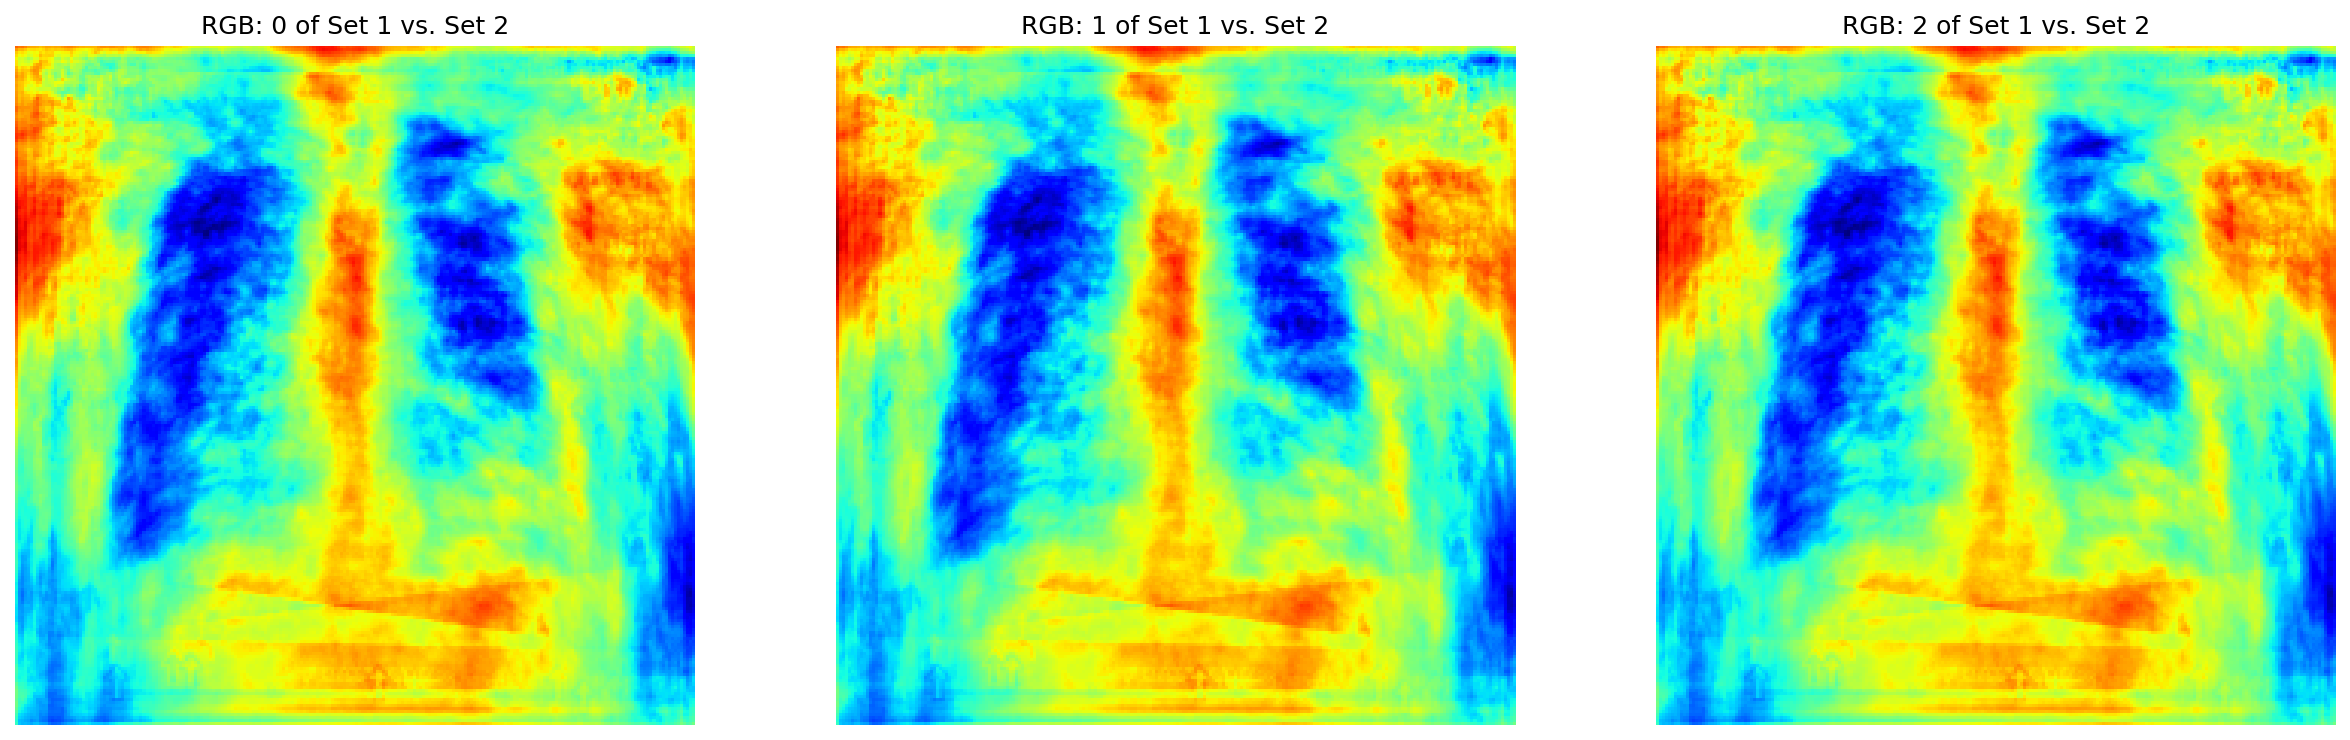

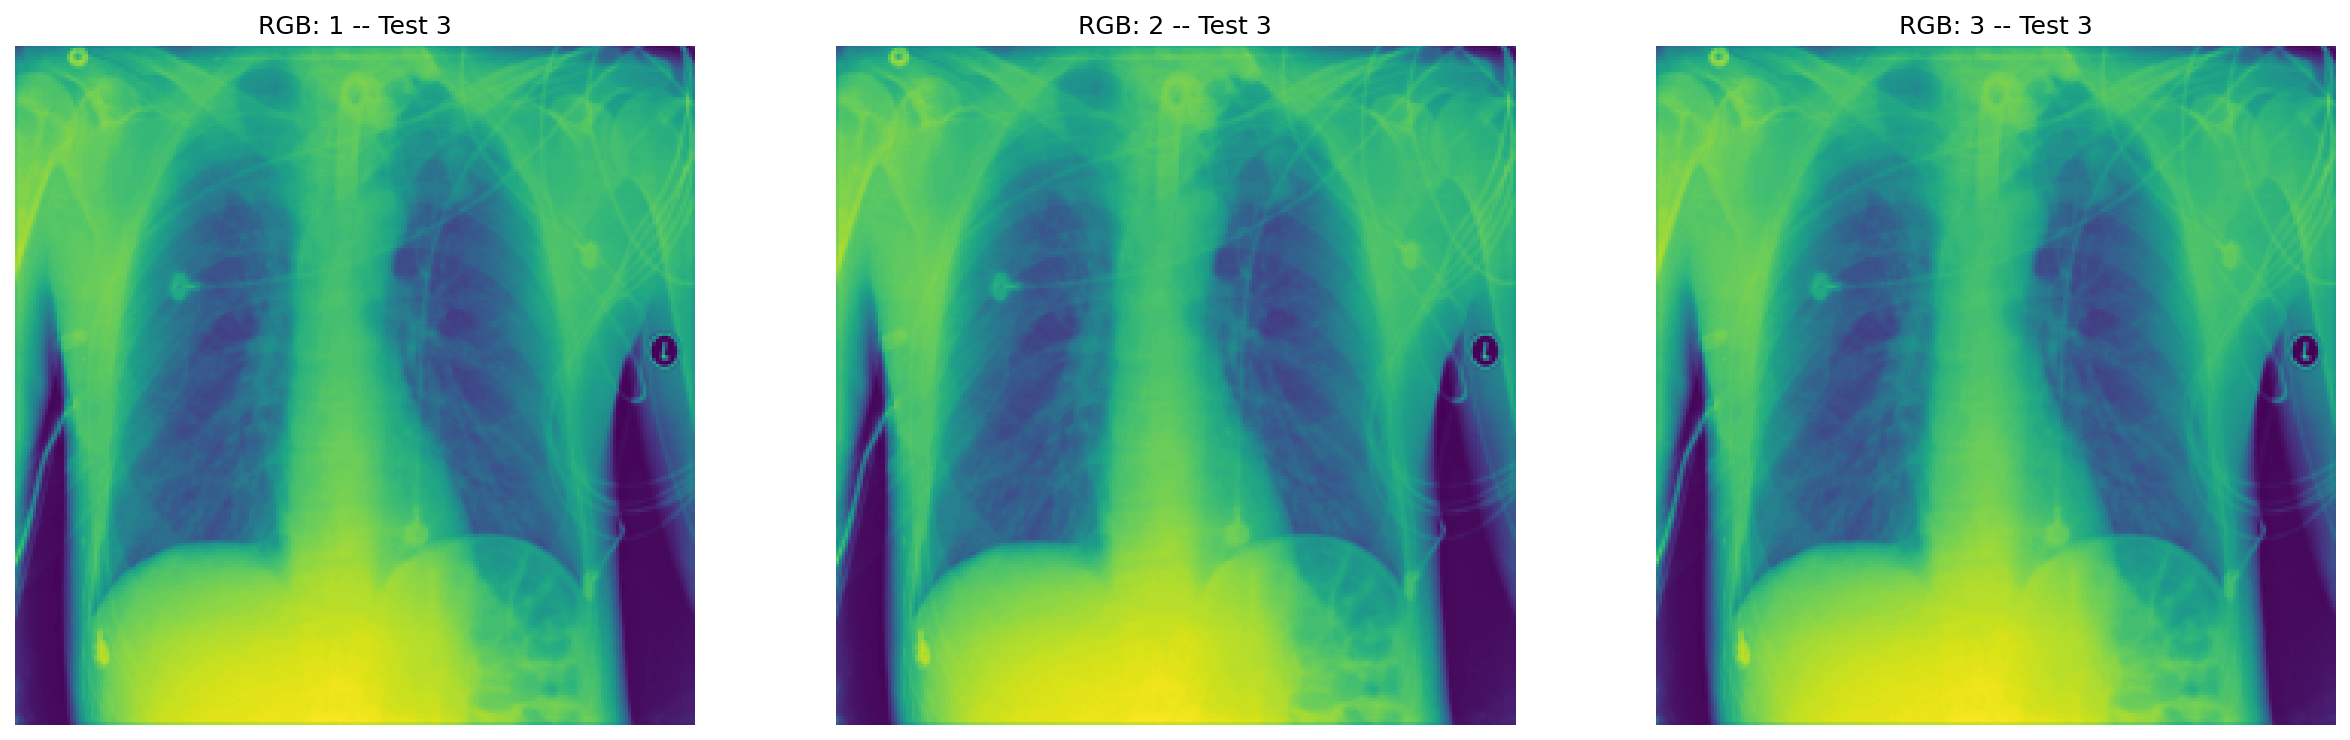

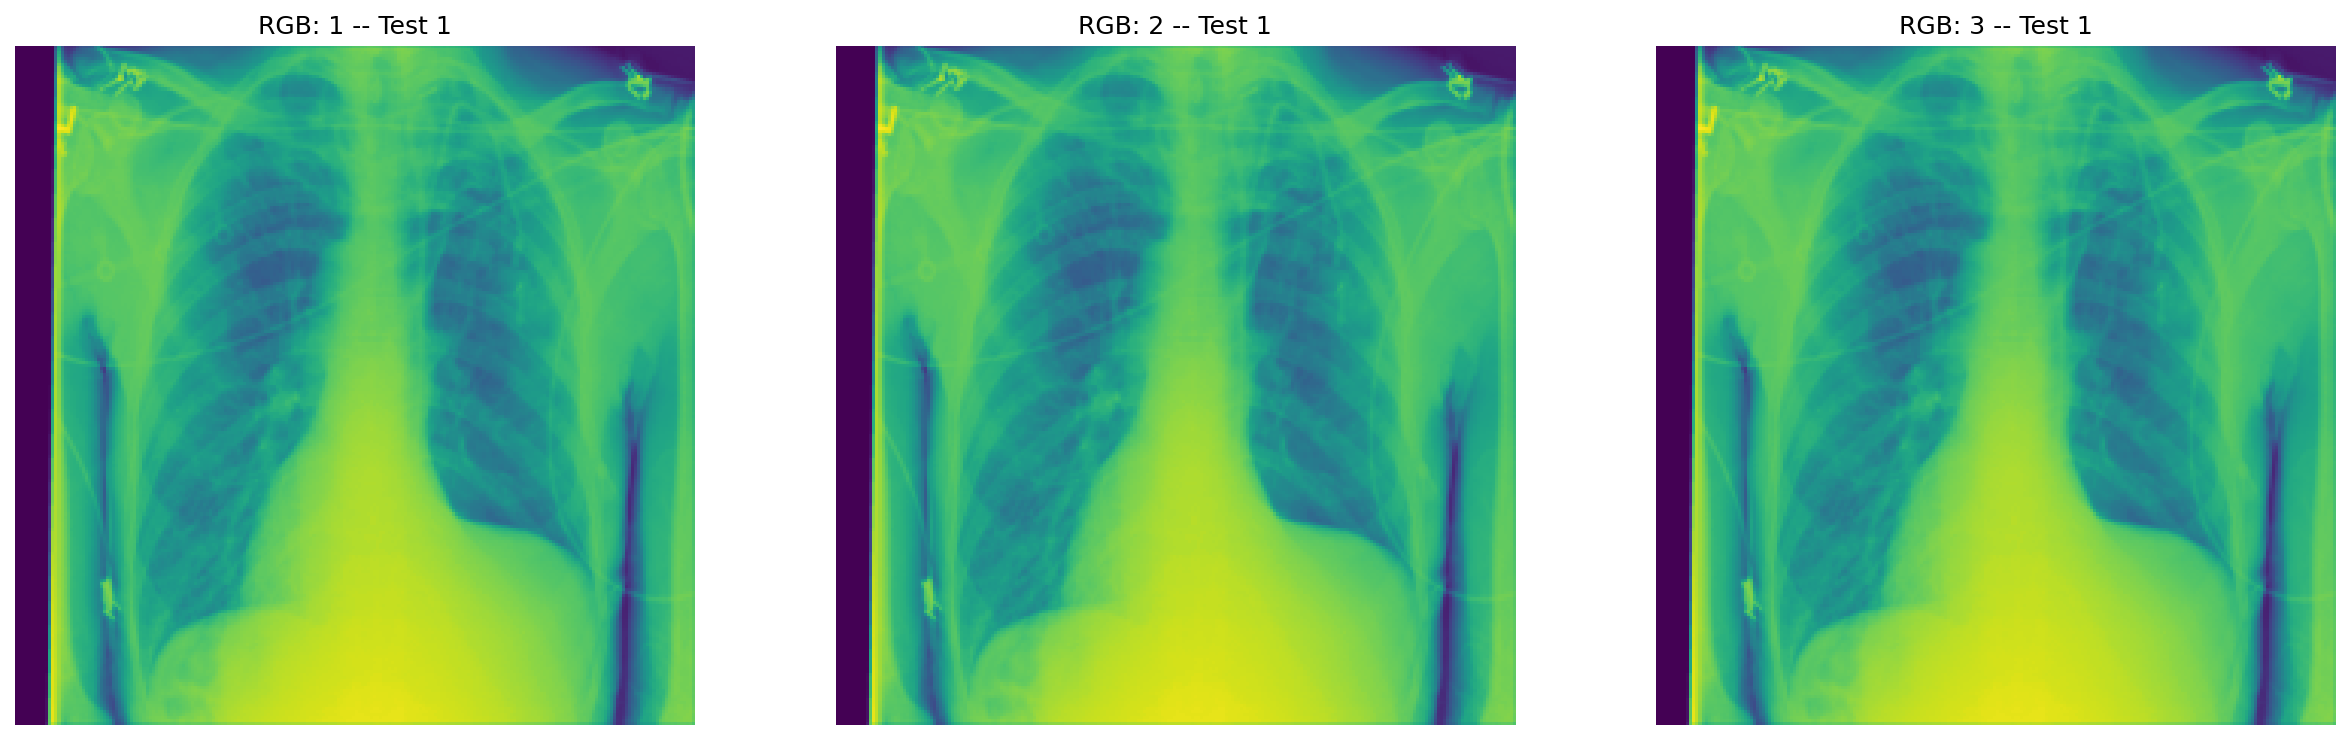

In [30]:
fig2, ax6 = pyplot.subplots(1,3, figsize = (20,6))

for ii, c_ax in enumerate(ax6.flatten()):
    # Comparing the training dataset sample with X_Test_wronge
    xxx,yyy = X_train[:,:,:,ii], wrong_preds[:,:,:,ii]
    yyy_2   = np.array([yy.flatten() for yy in yyy])
    xxx_2   = np.array([yy.flatten() for yy in xxx])
    snpm    = spm1d.stats.nonparam.ttest2(xxx_2[:224], yyy_2[:224])
    snpmi   = snpm.inference(0.05, two_tailed=True, iterations=1000) # Alpha is considered as 0.05
    
    J,Q     = xxx_2.shape
    z       = snpmi.z
    zstar   = snpmi.zstar
    z0      = np.zeros(Q)
    z0      = z
    Z0      = np.reshape(z0, (224,224))
    Z0i     = Z0.copy()
    Z0i[np.abs(Z0i)<zstar] = 0
    ZZ      = np.hstack( [Z0, Z0i] )
    
    c_ax.imshow(Z0, 'jet') # Can be replaced with Z0i
    c_ax.set_title('RGB: {} of Set {} vs. Set {}'.format(ii, 1,2))
    c_ax.axis('off')

fig3, ax7 = pyplot.subplots(1,3, figsize = (20,6))    

for ii, c_ax in enumerate(ax7.flatten()):
    c_ax.imshow(X_train[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, 3))
    c_ax.axis("off")
    
fig4, ax8 = pyplot.subplots(1,3, figsize = (20,6))     

for ii, c_ax in enumerate(ax8.flatten()):
    c_ax.imshow(wrong_preds[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, wrong_labels[1]))
    c_ax.axis('off')

print("End of block.")

## Applying LIME
As an experiment, we also applied LIME to the above example. 

In [ ]:
# ToDo